In [18]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

### Loading and preparing DNA methylation data

DNA methylation data is loaded from a file and reorganized so that the first row becomes the column names, and the first column becomes the index. This results in a clean and structured table ready for further analysis, as shown below.

In [2]:
data_path = 'OV.methylation__humanmethylation450__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.data.txt'
df = pd.read_csv(data_path, sep='\t')

/var/folders/_g/ncq8t9cn3y97t4_nz1ds47c40000gn/T/ipykernel_724/2888831559.py:2: DtypeWarning: Columns (1,4,5,8,9,12,13,16,17,20,21,24,25,28,29,32,33,36,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')


In [3]:
sample = df.columns # keep sample names

# changing structure of data frame
df.columns = df.iloc[0]
df = df.drop(0)
df = df.set_index(df.columns[0])

df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000108,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,...,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206
cg00000109,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,...,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294


In [4]:
# check NaN value
df.isna().sum()

0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89709
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89747
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89723
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89772
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89710
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89761
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89715
Gene_Symbol           119717
Chromosome  

In [5]:
# Before filtering genes with NaN values in Beta_value column, we count and save those rows 
beta_value_columns = [col for col in df.columns if 'Beta_value' in col]

count_rows_with_nan = df[beta_value_columns].isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN value in Beta_value columns: {count_rows_with_nan}")

# Saving
rows_with_nan = df[df[beta_value_columns].isna().any(axis=1)]
rows_with_nan.to_csv("rows_with_nan.csv", index=False)


Number of rows with at least one NaN value in Beta_value columns: 90002


In [6]:
# Filtering genes with NaN values in Beta_value column
df = df.dropna(subset=['Beta_value'])
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,ACTN1,14,69341139,0.53560092563212,ACTN1,...,14,69341139,0.45159368326575,ACTN1,14,69341139,0.718101311137447,ACTN1,14,69341139
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,ATP2A1,16,28890100,0.340245216172717,ATP2A1,...,16,28890100,0.929602191814778,ATP2A1,16,28890100,0.637718731276499,ATP2A1,16,28890100


#### Removing duplicate annotation columns

Next step removes redundant columns like Gene_Symbol, Chromosome, and Genomic_Coordinate, keeping only their first occurrence to simplify the dataset.

In [7]:
# Drop redundant Gene_symbol, Chromosome and Genomic_Coordinate columns

# Keep only the first occurrence of specific columns
columns_to_deduplicate = ['Chromosome', 'Gene_Symbol', 'Genomic_Coordinate']
df = df.loc[:, ~df.columns.duplicated(keep='first') | ~df.columns.isin(columns_to_deduplicate)]

# Check the updated DataFrame
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value
Composite Element REF,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,0.0712181967886229,0.0797617926225958,0.134907151266991,0.0541415985613948,0.0898579298345672,0.037865566345129,0.0681542463965581,0.101053013486289
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,0.0804679362519497,0.116847394499493,0.240761474867287,0.0731841811860166,0.117232830385723,0.44386976357312,0.218775162768368,0.091250661927779
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,0.873067094340102,0.916907354805292,0.899778425612948,0.886990509454191,0.902827859783123,0.914979623404746,0.894063237620977,0.909250402621734
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,0.53560092563212,0.671885140457963,0.529425616903779,0.638185069667011,0.470522232834328,0.68323363569591,0.45159368326575,0.718101311137447
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,0.340245216172717,0.846848323745542,0.793461162099088,0.394033633901396,0.457197228355476,0.920116383428113,0.929602191814778,0.637718731276499


In [8]:
# Before filtering data with significant methylation values, we save unfiltered date, NaN values dropped, redudant columns dropped
df.to_csv("unfiltered_df.csv", index=False)

#### Extracting Beta values and calculating variability

Only columns containing Beta_value are extracted. These values are converted to numbers, and the standard deviation is calculated for each row to measure variability. The result is stored in a new column called std_dev.

In [10]:
# Extract only Beta_value columns
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]

In [11]:
# Convert these values from string to float, calculate standard deviation and place it in the separate column
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')
std_dev = beta_values.std(axis=1)
df['std_dev'] = std_dev

#### Identifying significantly variable methylation sites

We calculate the mean and standard deviation of methylation variability (std_dev), and define thresholds for significance using two methods:

1. Two standard deviations above the mean

2. 95th percentile of the std_dev distribution

We then visualize the data using a histogram and a boxplot, and identify CpG sites with unusually high variability in methylation levels based on these thresholds.

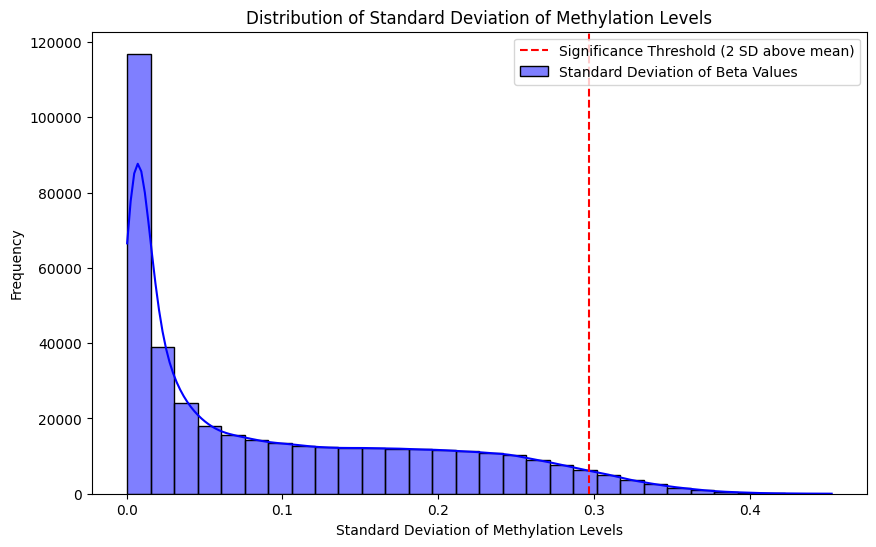

Threshold:  0.29687684557548
Number of significant methylation values: 16622


In [12]:
# Calculate the mean and standard deviation of the std_dev values
mean_std_dev = std_dev.mean()
std_dev_std_dev = std_dev.std()

# Set the threshold for significant methylation change (e.g., 2 standard deviations above the mean)
threshold = mean_std_dev + 2 * std_dev_std_dev

# Plot the histogram of standard deviations
plt.figure(figsize=(10, 6))
sns.histplot(std_dev, kde=True, color='blue', bins=30, label='Standard Deviation of Beta Values')

# Add a vertical line for the threshold
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Significance Threshold (2 SD above mean)')

# Add labels and title
plt.xlabel('Standard Deviation of Methylation Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Standard Deviation of Methylation Levels')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= threshold]
print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(significant)}")

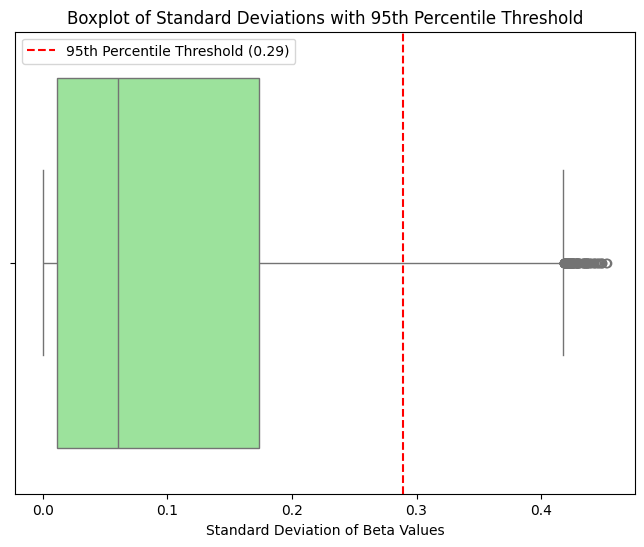

Percentile threshold:  0.2892595983816986
Number of significant methylation values: 19779


In [13]:
# Create a boxplot to visualize the distribution of the standard deviations of beta values
plt.figure(figsize=(8, 6))
sns.boxplot(data=std_dev, orient='h', color = 'lightgreen')

# Calculate the 95th percentile threshold
percentile_threshold = np.percentile(std_dev, 95)

# Overlay the threshold line
plt.axvline(x=percentile_threshold, color='red', linestyle='--', label=f'95th Percentile Threshold ({percentile_threshold:.2f})')

# Labels and title
plt.xlabel('Standard Deviation of Beta Values')
plt.title('Boxplot of Standard Deviations with 95th Percentile Threshold')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= percentile_threshold]
print("Percentile threshold: ", percentile_threshold)
print(f"Number of significant methylation values: {len(significant)}")

#### Filtering genes with significant methylation variation

We combine the two thresholds by averaging them to get a final cutoff. Then, we keep only the genes whose methylation variability exceeds this cutoff, removing the temporary variability column afterwards.

In [14]:
# Use mean value of obtained thresholds
threshold = (threshold + percentile_threshold) / 2

# Filter genes with significant variation in levels of methylation
df = df[df['std_dev'] >= threshold]
df = df.drop('std_dev', axis = 1)

print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(df)}")

Threshold:  0.2930682219785893
Number of significant methylation values: 18120


In [15]:
# Saving data frame with filtered genes with significant variation in levels of methylation
df.to_csv("filtered_df.csv", index=False)

#### Extracting Beta_value columns from filtered genes

From the filtered dataset, we select only the columns related to Beta values and convert them to numeric format for further analysis.

In [16]:
# Extract only Beta_value columns for filtered genes
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')
# Saving
beta_values.to_csv("beta_values.csv", index=False)

### Computing and visualizing correlations

We calculate the correlation matrix between CpG loci Beta values and visualize it with a heatmap to show how methylation levels at different sites relate to each other.

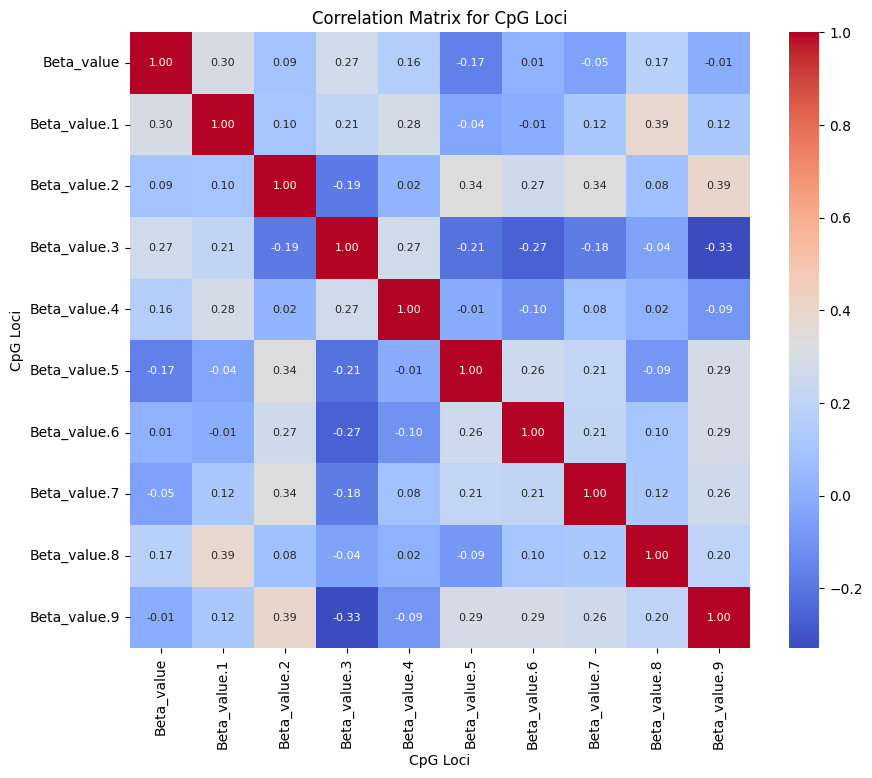

In [17]:
# Input file:
beta_values = pd.read_csv('beta_values.csv')

# Compute correlation matrix for CpG loci
correlation_matrix = beta_values.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix for CpG Loci')
plt.xlabel('CpG Loci')
plt.ylabel('CpG Loci')
plt.show()

#### Hierarchical clustering of CpG correlations

We apply hierarchical clustering to group CpG loci with similar methylation patterns, then visualize the clustered correlation matrix as a heatmap for clearer interpretation. For further discussion and detailed analysis of these results, please refer to the paper linked in this repository.

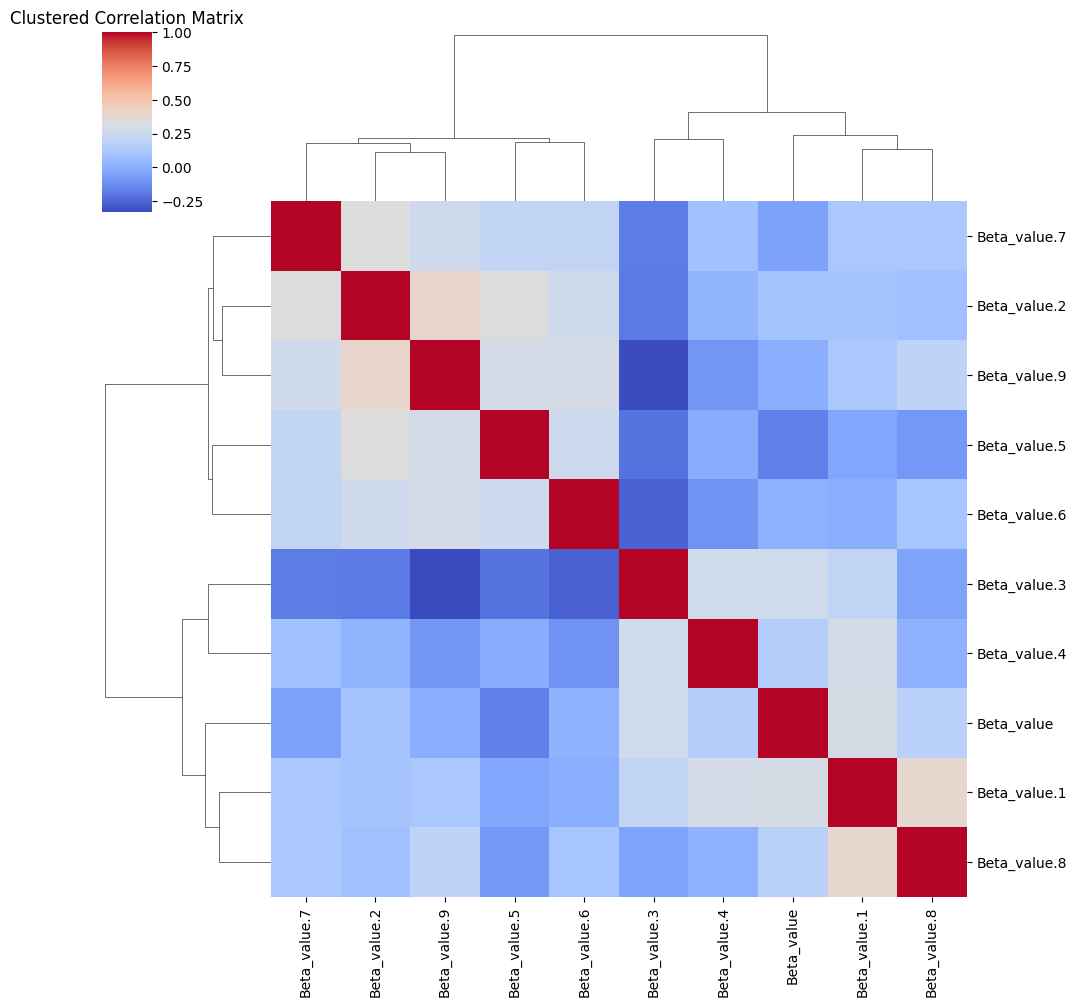

In [19]:
# Perform hierarchical clustering for better visualisation of correlations
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plot a clustered heatmap
sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(10, 10), row_linkage=linkage_matrix, col_linkage=linkage_matrix)
plt.title('Clustered Correlation Matrix')
plt.show()

## Clustering by CpG loci

Clustering groups CpG loci based on their methylation patterns, helping to identify similar behavior and biological insights.

### KMeans

We perform KMeans clustering on the Beta values, testing different numbers of clusters (from 2 to 14). For each clustering, we calculate three metrics — Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score — to assess how well the data groups. The Elbow Method and Silhouette Score are visualized to help select the optimal number of clusters. Finally, the best scores and corresponding parameters are printed.

n_clusters: 2, Silhouette Score: 0.1888, Calinski Harabasz: 4175.5390, Davies-Bouldin: 2.0398
n_clusters: 3, Silhouette Score: 0.1724, Calinski Harabasz: 3538.9779, Davies-Bouldin: 1.9800
n_clusters: 4, Silhouette Score: 0.1478, Calinski Harabasz: 3090.4343, Davies-Bouldin: 1.8727
n_clusters: 5, Silhouette Score: 0.1357, Calinski Harabasz: 2638.9922, Davies-Bouldin: 1.9524
n_clusters: 6, Silhouette Score: 0.1357, Calinski Harabasz: 2457.9960, Davies-Bouldin: 1.8783
n_clusters: 7, Silhouette Score: 0.1388, Calinski Harabasz: 2299.5870, Davies-Bouldin: 1.9231
n_clusters: 8, Silhouette Score: 0.1315, Calinski Harabasz: 2116.3896, Davies-Bouldin: 1.9750
n_clusters: 9, Silhouette Score: 0.1364, Calinski Harabasz: 2030.0288, Davies-Bouldin: 1.9322
n_clusters: 10, Silhouette Score: 0.1173, Calinski Harabasz: 1895.7746, Davies-Bouldin: 1.9372
n_clusters: 11, Silhouette Score: 0.1440, Calinski Harabasz: 1862.5831, Davies-Bouldin: 1.8400
n_clusters: 12, Silhouette Score: 0.1331, Calinski Harabas

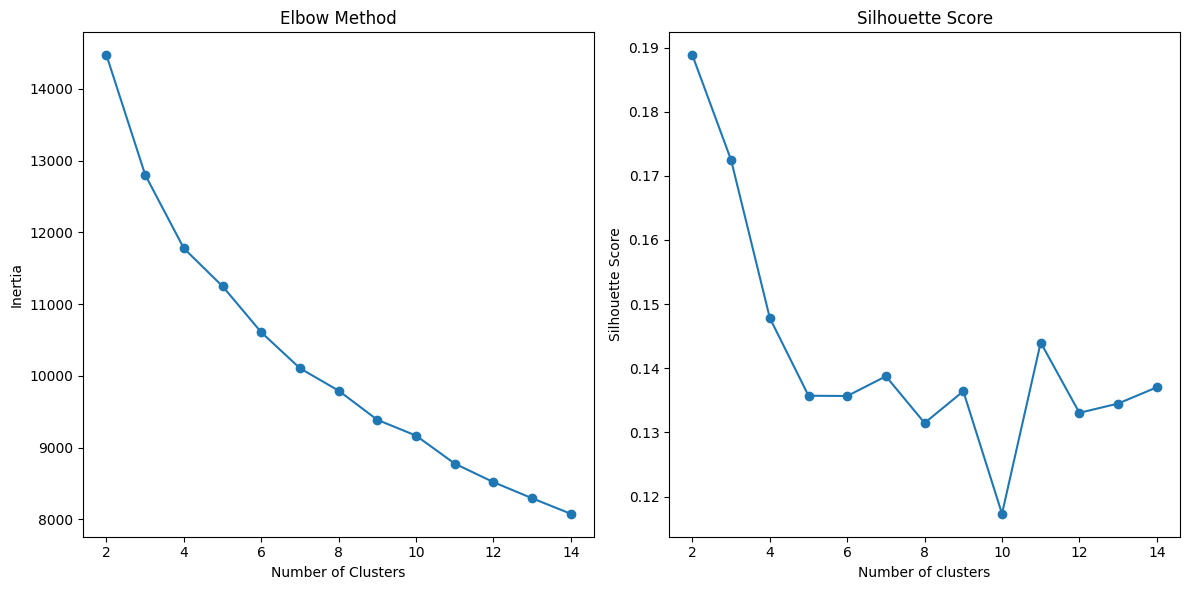


Best Results:
Best Silhouette Score: 0.1888 with parameters {'n_clusters': 2}
Best Calinski-Harabasz Score: 4175.5390 with parameters {'n_clusters': 2}
Best Davies-Bouldin Score: 1.7309 with parameters {'n_clusters': 14}


In [20]:
# Input file
beta_values = pd.read_csv('beta_values.csv')

param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize variables to store the best scores
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

# Store results for the Elbow Method and Silhouette scores
inertia = []
silhouette_scores = []

for params in grid_search:
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42)
    clusters = kmeans.fit_predict(beta_values)

    # Calculate metrics
    score_silhouette = silhouette_score(beta_values, clusters)
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    inertia.append(kmeans.inertia_)  # Elbow Method
    silhouette_scores.append(score_silhouette) 
    
    print(f"n_clusters: {params['n_clusters']}, "
          f"Silhouette Score: {score_silhouette:.4f}, "
          f"Calinski Harabasz: {score_calinski_harabasz:.4f}, "
          f"Davies-Bouldin: {score_davies_bouldin:.4f}"
)

    # Update the best scores and parameters
    if score_silhouette > best_silhouette_score:
        best_silhouette_score = score_silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params


# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')


# Silhouette score visualization
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Print the best results
print("\nBest Results:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} with parameters {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")

#### Determining the optimal number of clusters

Using the Elbow Method, we apply the KneeLocator to find the “elbow point” in the inertia plot, which suggests the best number of clusters to use for KMeans.

In [21]:
k_values = range(1, len(inertia) + 1)
knee_locator = KneeLocator(k_values, inertia, curve = "convex", direction="decreasing")
elbow_point = knee_locator.knee
print(f"The optimal number of clusters (elbow point) is: {elbow_point}")

The optimal number of clusters (elbow point) is: 5


- Silhouette and Calinski-Harabasz suggest n_clusters=2 as the optimal value.
- Davies-Bouldin and the Elbow Method suggest n_clusters=4–5 or possibly more.
- A low Silhouette Score and a gradually decreasing inertia suggest that the dataset may lack distinct clusters.
- The low scores across all metrics imply that the data may have overlapping clusters or no inherent cluster structure.
- Based on all this, we can conclude that KMeans is not appropriate algorithm for this clustering task.

### DBSCAN

DBSCAN is a clustering algorithm that groups points based on density, allowing detection of clusters with varying shapes and noise. First, we search for the optimal eps parameter by plotting distances to each point’s nearest neighbor to identify a good cutoff. After clustering, we evaluate the results using Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score to measure cluster quality.

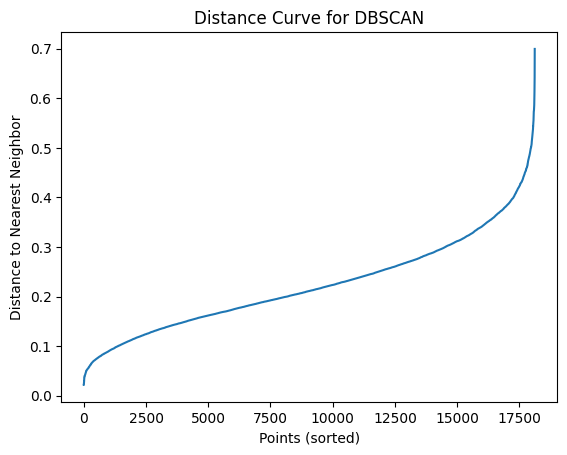

In [22]:
# Input file
beta_values = pd.read_csv('beta_values.csv')

# Searching for optimal eps value based on distance curve
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(beta_values)
distances, _ = neigh.kneighbors(beta_values)
distances = np.sort(distances, axis=0)[:, 1]

# Distance curve visualization
plt.plot(distances)
plt.title('Distance Curve for DBSCAN')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to Nearest Neighbor')
plt.show()


Based on the displayed curve, we can observe that a sudden increase occurs at the value eps = 0.4. Therefore, we will use this value to form the DBSCAN model. For the parameter min_samples, we will take, for example, the number 25, since we have a large number of points in the dataset.

In [23]:
dbscan = DBSCAN(eps=0.4, min_samples=25)
region_clusters = dbscan.fit_predict(beta_values)

# We can enumerate clusters and how many elements there are in each of them. Since data is 10-dimensional, its visualization is difficult
# to achieve, hence we will only enumerate clusters

counter = Counter(region_clusters)
sorted_clusters = {k : counter[k] for k in sorted(counter)}
print(sorted_clusters)

{-1: 5701, 0: 12272, 1: 101, 2: 46}


In [24]:
silhouette = silhouette_score(beta_values, region_clusters)
calinski = calinski_harabasz_score(beta_values, region_clusters)
davies = davies_bouldin_score(beta_values, region_clusters)
print(f"Silhouette Score: {silhouette:.4f}, "
  f"Calinski Harabasz: {calinski:.4f}, "
  f"Davies-Bouldin: {davies:.4f}")

Silhouette Score: 0.0332, Calinski Harabasz: 588.3179, Davies-Bouldin: 2.2992


- The results indicate that the clustering performance of DBSCAN with the current parameters is weak.
- The low Silhouette Score and high Davies-Bouldin Index highlight that the clusters are not distinct or meaningful.
- Based on all this, we can conclude that DBSCAN is not appropriate algorithm for this clustering task.

### Hierarchical clustering 

Hierarchical clustering builds a tree-like structure grouping CpG loci based on their methylation similarity. We test different numbers of clusters (from 2 to 14), evaluate cluster quality using Silhouette, Calinski-Harabasz, and Davies-Bouldin scores, and identify the best cluster count. Finally, a dendrogram visualizes the hierarchical grouping and the chosen cluster cut-off.

n_clusters: 2, Silhouette Score: 0.1215, Calinski Harabasz: 2754.2241, Davies-Bouldin: 2.3817
n_clusters: 3, Silhouette Score: 0.1357, Calinski Harabasz: 2655.8064, Davies-Bouldin: 2.2801
n_clusters: 4, Silhouette Score: 0.0938, Calinski Harabasz: 2328.9707, Davies-Bouldin: 2.1463
n_clusters: 5, Silhouette Score: 0.0960, Calinski Harabasz: 2039.6526, Davies-Bouldin: 2.3168
n_clusters: 6, Silhouette Score: 0.1003, Calinski Harabasz: 1856.0994, Davies-Bouldin: 2.1328
n_clusters: 7, Silhouette Score: 0.1072, Calinski Harabasz: 1734.3804, Davies-Bouldin: 2.3455
n_clusters: 8, Silhouette Score: 0.1127, Calinski Harabasz: 1649.5181, Davies-Bouldin: 2.1892
n_clusters: 9, Silhouette Score: 0.0891, Calinski Harabasz: 1557.7829, Davies-Bouldin: 2.1681
n_clusters: 10, Silhouette Score: 0.0933, Calinski Harabasz: 1490.4543, Davies-Bouldin: 2.0960
n_clusters: 11, Silhouette Score: 0.0857, Calinski Harabasz: 1430.1590, Davies-Bouldin: 2.0709
n_clusters: 12, Silhouette Score: 0.0899, Calinski Harabas

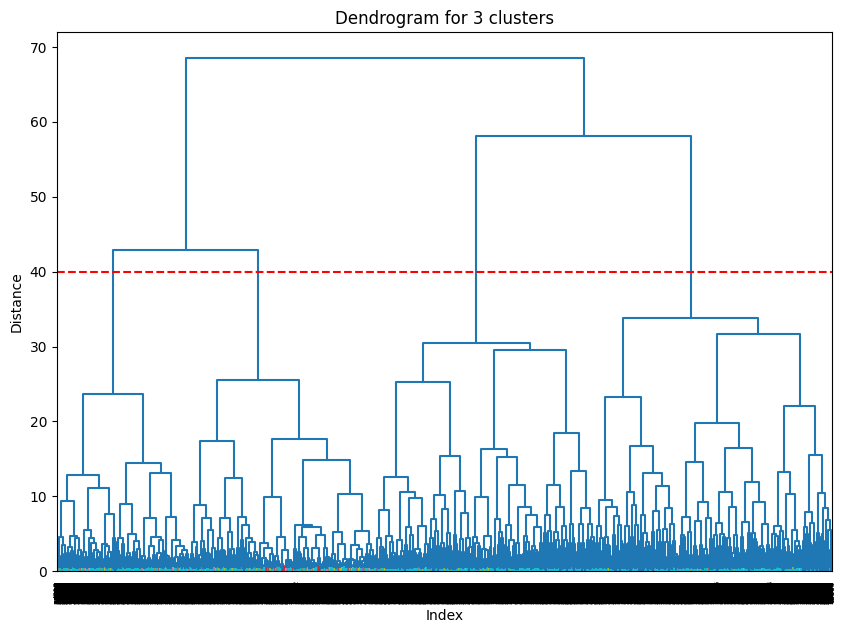

In [25]:
# Input file
beta_values = pd.read_csv('beta_values.csv')

param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize variables to store the best scores
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

silhouette_scores = []

linked = linkage(beta_values, method='ward')

for params in grid_search:
    clusters = fcluster(linked, t=params['n_clusters'], criterion='maxclust')
    score_silhouette = silhouette_score(beta_values, clusters)
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    
    silhouette_scores.append((params['n_clusters'], score_silhouette))

    print(f"n_clusters: {params['n_clusters']}, "
          f"Silhouette Score: {score_silhouette:.4f}, "
          f"Calinski Harabasz: {score_calinski_harabasz:.4f}, "
          f"Davies-Bouldin: {score_davies_bouldin:.4f}"
)

    # Update the best scores and parameters
    if score_silhouette > best_silhouette_score:
        best_silhouette_score = score_silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params


# Print the best results
print("\nBest Results:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} with parameters {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")


# Dendrogram for best number of clusters - regarding silhouette
best_n_clusters_sil = best_params_silhouette['n_clusters']
best_clusters = fcluster(linked, t=best_n_clusters_sil, criterion='maxclust')
plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.7)
plt.axhline(y=40, color='r', linestyle='--')
plt.title(f'Dendrogram for {best_n_clusters_sil} clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

- The low Silhouette and high Davies-Bouldin Scores suggest that this dataset does not have a strong inherent cluster structure or that the chosen distance metric/linkage method might not be capturing the data's true relationships.
- While the metrics highlight different optimal cluster counts (n_clusters=3 for Silhouette, n_clusters=2 for Calinski-Harabasz, and n_clusters=13 for Davies-Bouldin), none indicate a strong, meaningful clustering structure.
- Based on all this, we can conclude that Hierarchical clustering is not appropriate algorithm for this clustering task.

### GMM

GMM clusters data by assuming it is a mixture of several Gaussian distributions. We test different numbers of clusters and evaluate cluster quality using metrics like Silhouette Score, Calinski-Harabasz, Davies-Bouldin, as well as statistical criteria AIC, BIC, and Log-Likelihood. These metrics help determine the best model fit and cluster count. Results for AIC and BIC are visualized to assist selection.

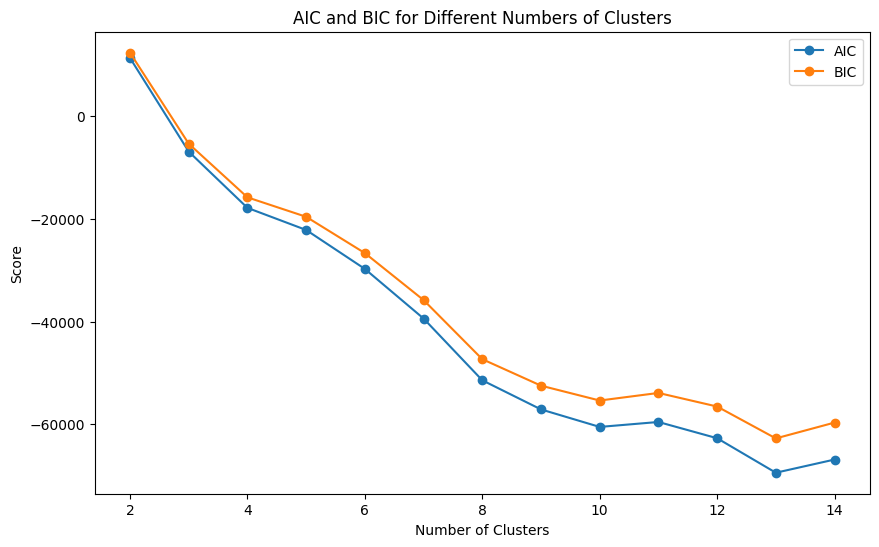

Best Scores and Parameters:
Best Silhouette Score: 0.1238 at {'n_clusters': 2}
Best Calinski-Harabasz Score: 2913.4824 with parameters {'n_clusters': 2}
Best Davies-Bouldin Score: 2.3187 with parameters {'n_clusters': 2}
Best AIC: -69459.1287 at {'n_clusters': 13}
Best BIC: -62770.4394 at {'n_clusters': 13}
Best Log-Likelihood: 35586.5643 at {'n_clusters': 13}


In [26]:
# Input file
beta_values = pd.read_csv('beta_values.csv')

param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize best score variables
best_silhouette_score = -1
best_aic = float('inf')  # Lower is better
best_bic = float('inf')  # Lower is better
best_log_likelihood = -float('inf')  # Higher is better
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better


# Initialize best parameter trackers
best_params_silhouette = None
best_params_aic = None
best_params_bic = None
best_params_log_likelihood = None
best_params_calinski = None
best_params_davies = None

results = []
aic_scores = []
bic_scores = []

for params in grid_search:
    gmm = GaussianMixture(n_components=params['n_clusters'], random_state=42)
    clusters = gmm.fit_predict(beta_values)

    silhouette = silhouette_score(beta_values, clusters) 
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    aic = gmm.aic(beta_values)
    bic = gmm.bic(beta_values)
    log_likelihood = gmm.score(beta_values) * len(beta_values)  # Total log-likelihood

    aic_scores.append(aic)
    bic_scores.append(bic)
    
    if silhouette is not None and silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_params_silhouette = params
    
    if aic < best_aic:
        best_aic = aic
        best_params_aic = params
    
    if bic < best_bic:
        best_bic = bic
        best_params_bic = params
  
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_params_log_likelihood = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params
    

# Visualization of AIC and BIC results
plt.figure(figsize=(10, 6))
plt.plot(range(2,15), aic_scores, label='AIC', marker='o')
plt.plot(range(2,15), bic_scores, label='BIC', marker='o')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

# Print best scores and parameters
print("Best Scores and Parameters:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} at {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")
print(f"Best AIC: {best_aic:.4f} at {best_params_aic}")
print(f"Best BIC: {best_bic:.4f} at {best_params_bic}")
print(f"Best Log-Likelihood: {best_log_likelihood:.4f} at {best_params_log_likelihood}")

- 2 Clusters: Metrics like Silhouette Score, Calinski-Harabasz, and Davies-Bouldin suggest that the data can be divided into 2 broad groups, but the clusters are not particularly distinct.
- 13 Clusters: AIC, BIC, and Log-Likelihood indicate that the data may support a more granular division with 13 clusters, though this could result in overfitting or noise-driven clustering.
- None of the metrics indicate exceptionally strong clustering performance

### Spectral Clustering

Spectral Clustering groups data points based on graph theory, useful for detecting complex cluster structures. Here, we test different cluster numbers and evaluate the quality with Silhouette, Calinski-Harabasz, and Davies-Bouldin metrics to find the optimal clustering configuration.

In [27]:
# Input file:
beta_values = pd.read_csv('beta_values.csv')

# Apply Spectral Clustering for different number of clusters, searching for the most optimal one
best_silhouette = -1
optimal_silhouette = None # optimal number of clusters
best_calinski_harabasz = -1
optimal_calinski = None
best_davies_bouldin = float('inf')  # Lower is better
optimal_davies = None

for n_cluster in range(2, 10):
    spectral = SpectralClustering(n_clusters=n_cluster, affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(beta_values.T)
    sil = silhouette_score(beta_values.T, clusters)
    cal = calinski_harabasz_score(beta_values.T, clusters)
    dav = davies_bouldin_score(beta_values.T, clusters)
    if sil > best_silhouette:
        best_silhouette = sil
        optimal_silhouette = n_cluster
    if cal > best_calinski_harabasz:
        best_calinski_harabasz = cal
        optimal_calinski = n_cluster
    if dav < best_davies_bouldin:
        best_davies_bouldin = dav
        optimal_davies = n_cluster
    
# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette:.4f} Number of clusters: {optimal_silhouette}")
print(f"Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f} Number of clusters: {optimal_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin:.4f} Number of clusters: {optimal_davies}")


Best Silhouette Score: -0.0161 Number of clusters: 2
Best Calinski-Harabasz Index: 1.3719 Number of clusters: 7
Best Davies-Bouldin Score: 0.6350 Number of clusters: 9


- The metrics suggest that Spectral Clustering struggles to find clear, well-separated clusters in data.
- While the Davies-Bouldin Score for 9 clusters is relatively good, the poor Silhouette Score and low Calinski-Harabasz Index indicate that the clustering structure is weak overall.

### Data visualisation

##### Data Visualization with PCA
We use Principal Component Analysis (PCA) to reduce the high-dimensional Beta values to 2D and 3D components for easier visualization. This helps us see patterns and groupings in the data. The 2D plot shows the first two principal components, while the 3D plots display three components from multiple viewpoints to better understand the data structure.

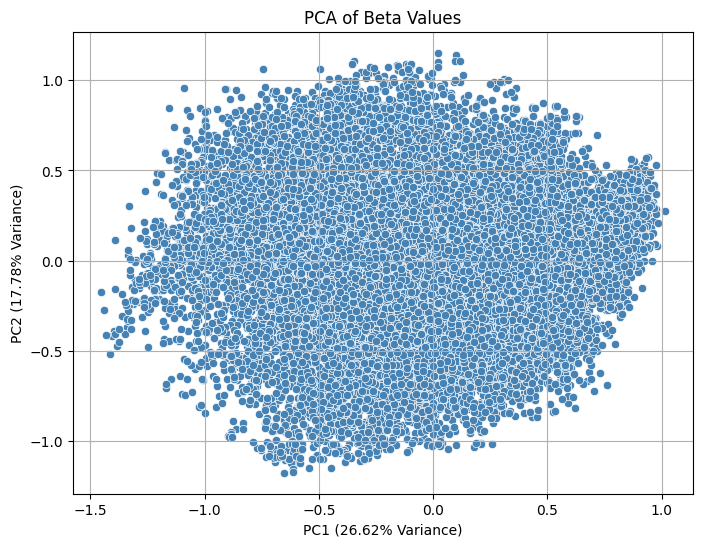

In [28]:
# Input file
beta_values = pd.read_csv('beta_values.csv')

pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(beta_values)
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

if 'Label' in locals(): 
    pca_df['Label'] = labels

# Plot
plt.figure(figsize=(8, 6))
if 'Label' in pca_df:
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Label', palette='viridis')
    plt.legend(title='Label', loc='best')
else:
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, color='steelblue')

plt.title('PCA of Beta Values')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)')
plt.grid()
plt.show()

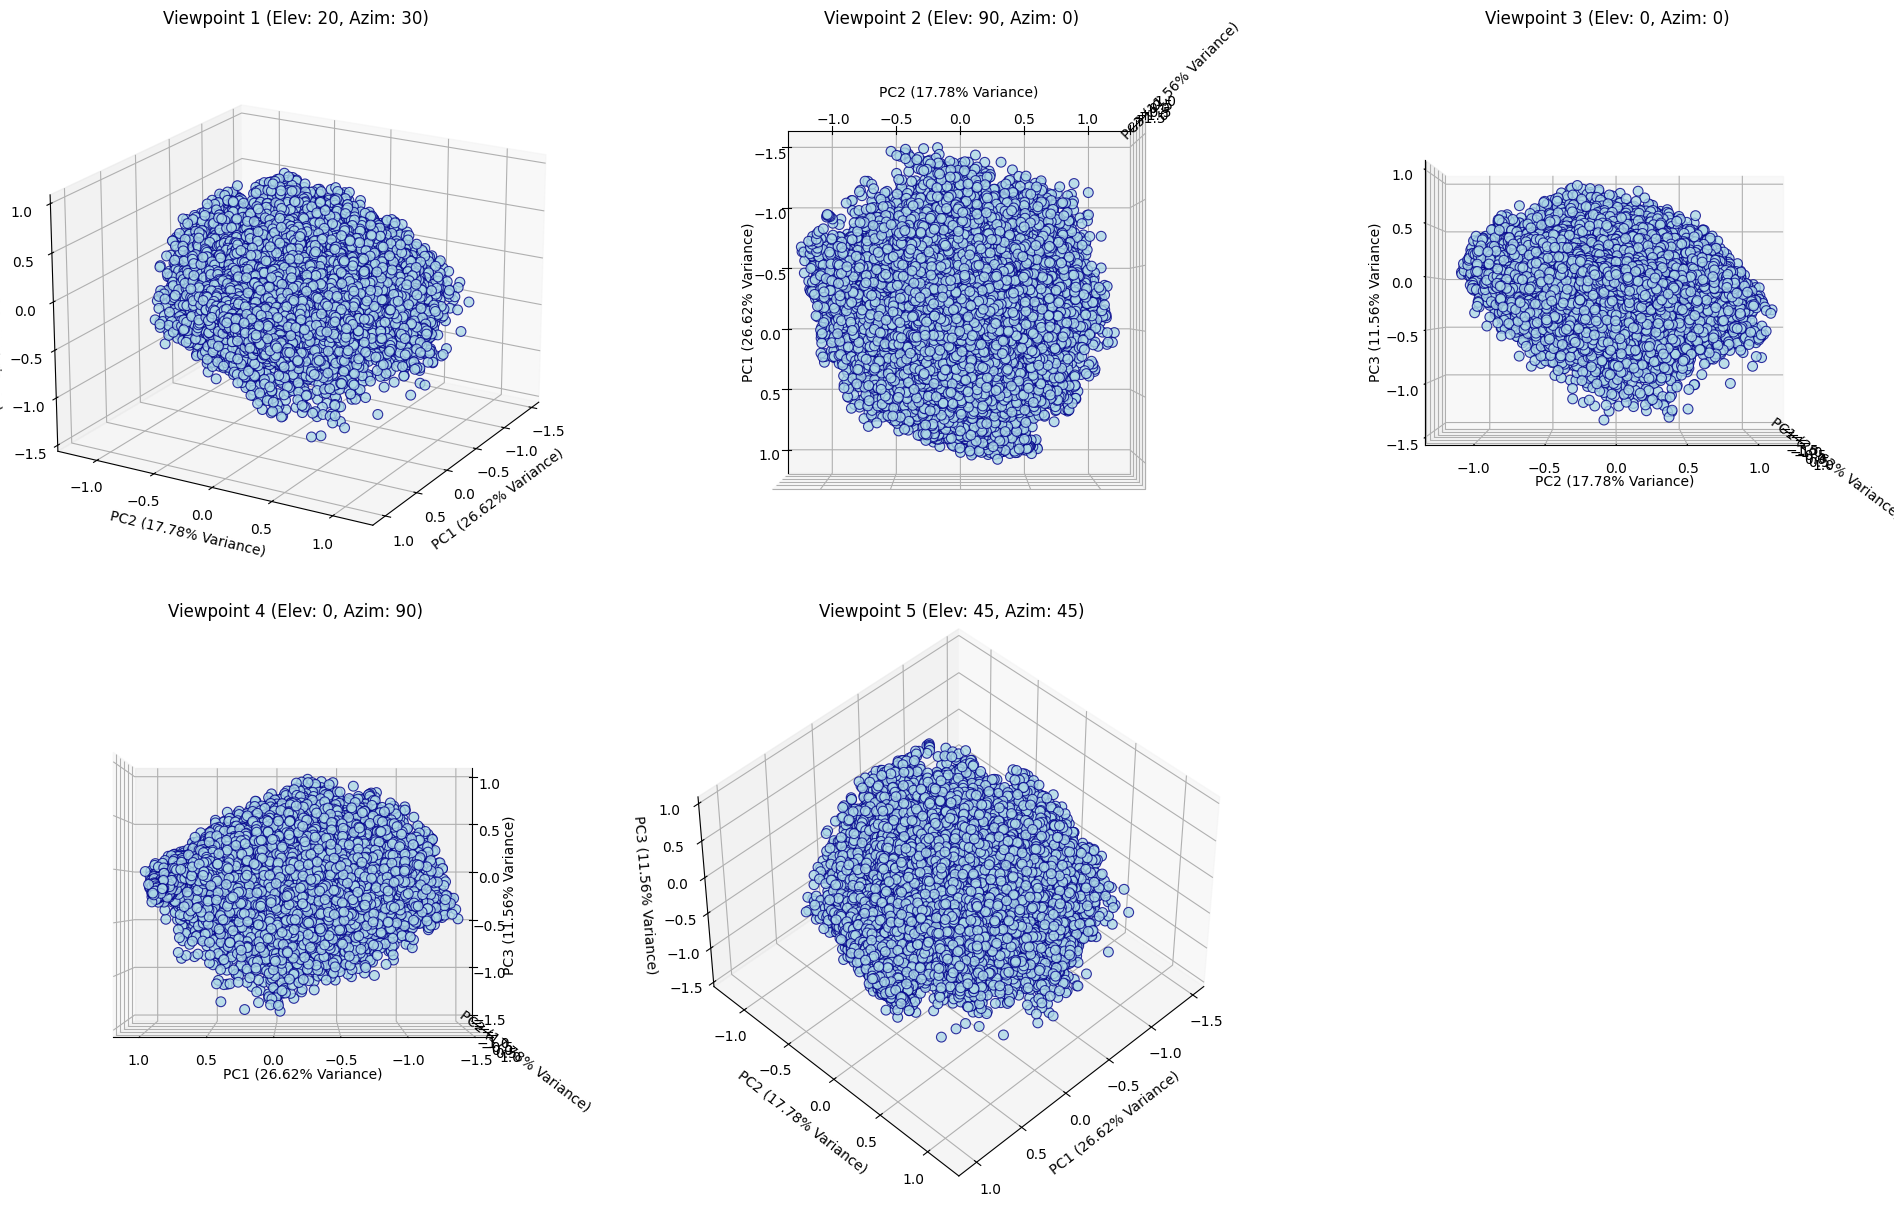

In [29]:
pca = PCA(n_components=3)  # Reduce to 3 components for 3D visualization
principal_components = pca.fit_transform(beta_values)
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

if 'Label' in locals(): 
    pca_df['Label'] = labels

# Define viewpoints (elevation, azimuth)
viewpoints = [
    (20, 30),   # Default view
    (90, 0),    # Top-down view
    (0, 0),     # Front view
    (0, 90),    # Side view
    (45, 45)    # Isometric view
]

# Plot from multiple viewpoints
fig = plt.figure(figsize=(20, 12))

for i, (elev, azim) in enumerate(viewpoints, start=1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    
    # Scatter plot
    if 'Label' in pca_df:
        categories = pca_df['Label'].astype('category').cat.codes
        scatter = ax.scatter(
            pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
            c='lightblue',  # Inside color
            edgecolors='darkblue',  # Border color
            linewidth=0.8,  # Border thickness
            alpha=0.8,  # Transparency
            s=50  # Size of the points
        )
        if i == 1:  # Add legend only to the first subplot
            legend = ax.legend(*scatter.legend_elements(), title="Label")
            ax.add_artist(legend)
    else:
        ax.scatter(
            pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
            c='lightblue', edgecolors='darkblue', linewidth=0.8, alpha=0.8, s=50
        )
    
    # Set view angles
    ax.view_init(elev=elev, azim=azim)
    
    # Customize axes
    ax.set_title(f'Viewpoint {i} (Elev: {elev}, Azim: {azim})')
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)')
    ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}% Variance)')

plt.tight_layout()
plt.show()

- Based on the clustering results we obtained using KMeans, DBSCAN, hierarchical clustering, spectral clustering, and Gaussian Mixture Models (GMM), the performance metrics were suboptimal across all methods.
- Upon visualizing the data, it appears that the clusters are poorly defined. The data points seem to overlap significantly, and there is little to no clear separation between potential clusters. This suggests that the data may inherently belong to a single cluster, making clustering algorithms ineffective in this scenario.

## Region clustering

##### Region Clustering of CpG Loci
CpG loci are specific sites along the genome where DNA methylation occurs. Instead of analyzing each locus separately, we group nearby loci into genomic windows of fixed size (here, 16,330 base pairs) to study local methylation patterns.

First, the data is sorted by chromosome and genomic coordinate, then each locus is assigned to a window based on its position. Within each window, we calculate the average correlation of methylation levels between all CpG loci, measuring how similarly they behave locally.

Windows with high average correlation (above the 95th percentile) indicate regions where methylation levels are strongly coordinated. These windows are merged into larger regions, allowing us to identify boundaries where methylation patterns change sharply, which may reflect biologically meaningful genomic segments.

The code following this explanation performs these steps:

* Sorting and assigning loci to windows,

* Calculating average correlations within windows,

* Detecting high-correlation windows as potential region boundaries,

* Grouping windows into regions,

* Creating a summary table of these regions for further clustering analysis (regions_df).

In [30]:
# Input file
df = pd.read_csv('filtered_df.csv')

# Set the window size (16,330 base pairs)
window_size = 16330

# Ensure Genomic_Coordinate is numeric and sort data by chromosome and coordinate
df['Genomic_Coordinate'] = df['Genomic_Coordinate'].astype(int)
df_sorted = df.sort_values(by=['Chromosome', 'Genomic_Coordinate'])

# Assign each CpG locus to a window
df_sorted['Window'] = df_sorted['Genomic_Coordinate'] // window_size

# Group loci by window
grouped_windows = df_sorted.groupby(['Chromosome', 'Window'])

# Compute correlations and identify boundaries
window_mean_correlations = []

for (chromosome, window), group in grouped_windows:
    # Extract beta values for loci in this window
    beta_values_window = group.filter(like='Beta_value', axis=1)

    # Detect and exclude constant columns
    constant_columns = (beta_values_window.nunique() <= 1)
    if constant_columns.any():
        beta_values_window = beta_values_window.loc[:, ~constant_columns]
    
    # Compute mean correlation within the window
    if beta_values_window.shape[1] > 1:
        correlation_matrix = beta_values_window.corr()
        mean_correlation = correlation_matrix.stack().mean()
    else:
        mean_correlation = 0  # Single CpG in the window
    
    window_mean_correlations.append(mean_correlation)

# Detecting boundaries of region with sharp changes in methylation levels
threshold = np.percentile(window_mean_correlations, 95)
boundaries = [i for i, corr in enumerate(window_mean_correlations) if corr > threshold]

In [31]:
len(boundaries)

507

In [32]:
region_ranges = []

# Convert boundaries into region ranges
start = 0
for boundary in boundaries:
    region_ranges.append((start, boundary))
    start = boundary + 1
    
regions = []
for region in region_ranges:
    start, end = region
    region_data = df_sorted[(df_sorted['Window'] >= start) & (df_sorted['Window'] <= end)]
    mean_correlation = np.mean(window_mean_correlations[start:end + 1])
    
    # Append features for the region
    regions.append({
        'Mean_Correlation': mean_correlation
    })

# Create a DataFrame for clustering
regions_df = pd.DataFrame(regions)

In [33]:
regions_df.shape

(507, 1)

In [34]:
regions_df.head()

,Mean_Correlation
0,0.500000
1,0.221756
2,0.139747
3,0.778598
4,0.852149


In [35]:
# Saving
regions_df.to_csv("regions_df.csv", index = False)

### KMeans

We perform KMeans clustering on the summarized regions, using the average correlation within each region as the input data. We explore different numbers of clusters (from 2 to 10) and assess the clustering quality using metrics like inertia (Elbow method), Silhouette Score, Calinski-Harabasz, and Davies-Bouldin to find the best cluster count.

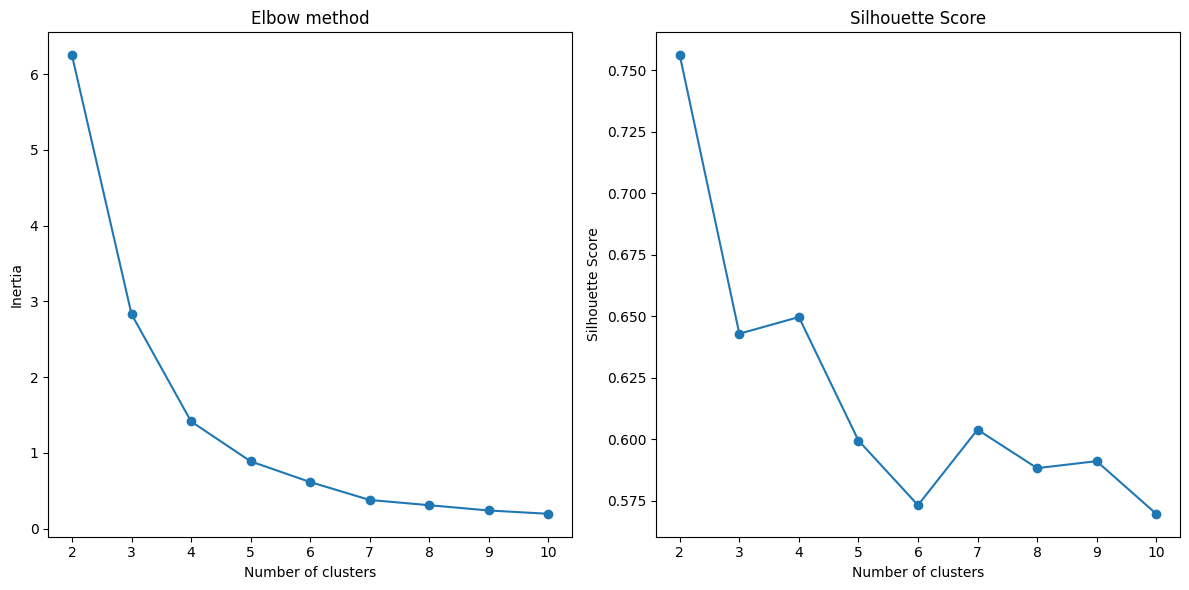

Silhouette score of 0.756174413354461 suggests 2 clusters.
Calinski Harabasz score of 5984.275468787464 suggests 10 clusters.
Davies Bouldin score of 0.5064310892305759 suggests 3 clusters.


In [36]:
# Input file
regions_df = pd.read_csv('regions_df.csv')

max_clusters = 10
inertias = []
silhouette_scores = []
calinski_scores = []
davies_scores = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(regions_df[['Mean_Correlation']])
    inertias.append(kmeans.inertia_)

    silhouette = silhouette_score(regions_df[['Mean_Correlation']], kmeans.labels_)
    silhouette_scores.append(silhouette)
    calinski = calinski_harabasz_score(regions_df[['Mean_Correlation']], kmeans.labels_)
    calinski_scores.append(calinski)
    davies = davies_bouldin_score(regions_df[['Mean_Correlation']], kmeans.labels_)
    davies_scores.append(davies)


# Elbow method visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette score visualization
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2  # e.g. 5th element is the maximum -> 5 + 2 = 7 clusters
print(f"Silhouette score of {max(silhouette_scores)} suggests {optimal_k_silhouette} clusters.")
optimal_k_calinski = calinski_scores.index(max(calinski_scores)) + 2
print(f"Calinski Harabasz score of {max(calinski_scores)} suggests {optimal_k_calinski} clusters.")
optimal_k_davies = davies_scores.index(max(davies_scores)) + 2
print(f"Davies Bouldin score of {max(davies_scores)} suggests {optimal_k_davies} clusters.")

Considering the above elbow graph, we can say that optimal number of clusters (where the decrease rate doesn't further significantly drop) is around 7, hence the optimal number of clusters would be 7.

### DBSCAN

To optimize DBSCAN clustering, we first determine the best eps value by plotting the sorted distances to each point’s nearest neighbor and identifying the "elbow" point on this curve, which indicates a natural radius for cluster formation.

With the optimal eps fixed, we vary the min_samples parameter to test different minimum cluster sizes. For each min_samples, we run DBSCAN on the region data and calculate clustering quality metrics: Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Score.

This process helps find the combination of eps and min_samples that yields the most meaningful clustering structure, balancing cluster cohesion and separation.

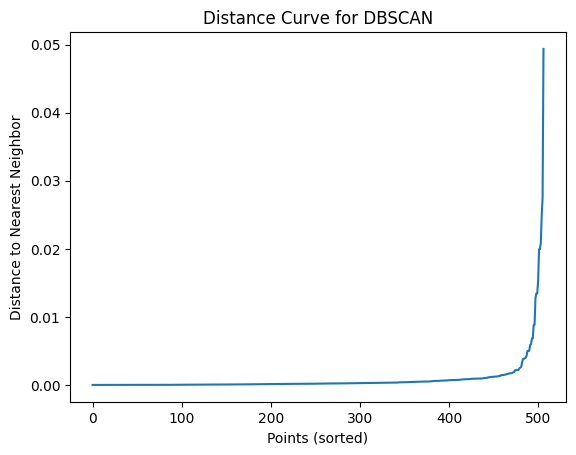

In [37]:
# Input file
regions_df = pd.read_csv('regions_df.csv')

# Finding optimal eps using Distance Curve 
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(regions_df)
distances, _ = neigh.kneighbors(regions_df)
sorted_distances = np.sort(distances[:, 1]) 

# Visualising distance curve
import matplotlib.pyplot as plt
plt.plot(sorted_distances)
plt.title('Distance Curve for DBSCAN')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to Nearest Neighbor')
plt.show()

In [38]:
# Detect the elbow point
knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
optimal_eps = sorted_distances[knee_locator.knee]

print(f"Optimal eps value: {optimal_eps:.4f}")

Optimal eps value: 0.0199


In [39]:
# Define a range of min_samples values to test
min_samples_range = range(3, 15)

# Track the best results for each metric
best_silhouette_score = -1
best_calinski_score = -1
best_davies_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

for min_samples in min_samples_range:
    # Apply DBSCAN with fixed eps and varying min_samples
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(regions_df)
    
    # Check if there are at least 2 clusters (otherwise metrics are invalid)
    if len(set(labels)) > 1:
        # Compute clustering metrics
        silhouette = silhouette_score(regions_df, labels)
        calinski = calinski_harabasz_score(regions_df, labels)
        davies = davies_bouldin_score(regions_df, labels)
        
        n_clusters = len(np.unique(labels))
        
        print(f"min_samples: {min_samples}, "
          f"Silhouette Score: {silhouette:.4f}, "
          f"Calinski Harabasz: {calinski:.4f}, "
          f"Davies-Bouldin: {davies:.4f}, "
          f"Number of Clusters: {n_clusters}"
)
        
        # Update best Silhouette Score
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_params_silhouette = (min_samples, n_clusters)
        
        # Update best Calinski-Harabasz Index
        if calinski > best_calinski_score:
            best_calinski_score = calinski
            best_params_calinski = (min_samples, n_clusters)
        
        # Update best Davies-Bouldin Score
        if davies < best_davies_score:
            best_davies_score = davies
            best_params_davies = (min_samples, n_clusters)

# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette_score:.4f} at min_samples={best_params_silhouette[0]}. Number of clusters: {best_params_silhouette[1]}")
print(f"Best Calinski-Harabasz Index: {best_calinski_score:.4f} at min_samples={best_params_calinski[0]}. Number of clusters: {best_params_calinski[1]}")
print(f"Best Davies-Bouldin Score: {best_davies_score:.4f} at min_samples={best_params_davies[0]}. Number of clusters: {best_params_davies[1]}")


min_samples: 3, Silhouette Score: 0.6037, Calinski Harabasz: 307.2693, Davies-Bouldin: 0.7997, Number of Clusters: 7
min_samples: 4, Silhouette Score: 0.6037, Calinski Harabasz: 307.2693, Davies-Bouldin: 0.7997, Number of Clusters: 7
min_samples: 5, Silhouette Score: 0.5989, Calinski Harabasz: 363.7460, Davies-Bouldin: 0.5921, Number of Clusters: 6
min_samples: 6, Silhouette Score: 0.5760, Calinski Harabasz: 368.5578, Davies-Bouldin: 0.5567, Number of Clusters: 7
min_samples: 7, Silhouette Score: 0.5378, Calinski Harabasz: 347.3726, Davies-Bouldin: 1.2247, Number of Clusters: 7
min_samples: 8, Silhouette Score: 0.5778, Calinski Harabasz: 479.5874, Davies-Bouldin: 2.6394, Number of Clusters: 5
min_samples: 9, Silhouette Score: 0.6723, Calinski Harabasz: 624.3237, Davies-Bouldin: 1.4568, Number of Clusters: 4
min_samples: 10, Silhouette Score: 0.6723, Calinski Harabasz: 624.3237, Davies-Bouldin: 1.4568, Number of Clusters: 4
min_samples: 11, Silhouette Score: 0.7172, Calinski Harabasz: 9

- Across all three metrics, the optimal number of clusters is consistently 3, which strongly suggests that your data naturally forms three distinct groups.
- The results highlight the importance of min_samples, as both 11 and 14 yield strong metrics. The slightly lower value of 11 provides the best overall clustering based on Silhouette and Davies-Bouldin scores.

Using the previously determined optimal parameters (eps and min_samples), DBSCAN is applied to the regional data to assign cluster labels, including identification of noise points (labeled as -1).

The resulting clusters are visualized in a scatter plot of mean correlation values across regions. A corresponding color map is shown to distinguish different clusters and noise points for clear interpretation of the clustering results.

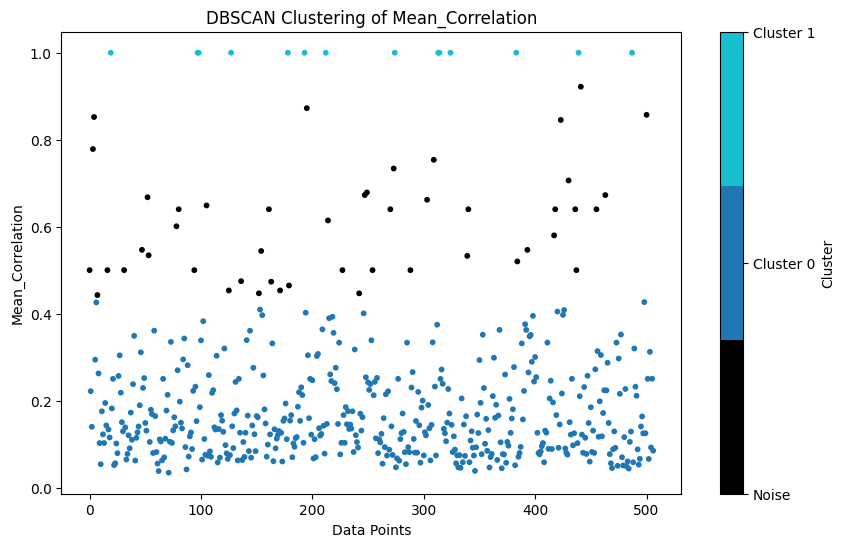

In [40]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=11)
clusters = dbscan.fit_predict(regions_df)
regions_df['Cluster'] = clusters

# Define a custom colormap where -1 (noise) is black and other clusters use high-contrast colors
unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use 'tab10' for better contrast
colors = np.vstack(([[0, 0, 0, 1]], colors))  # Add black color for noise
custom_cmap = ListedColormap(colors)

# Scatter plot for Mean_Correlation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(range(len(regions_df)), 
                       regions_df['Mean_Correlation'], 
                       c=regions_df['Cluster'], 
                       cmap=custom_cmap, 
                       s=10)

# Customize the color bar to label -1 as "Noise"
cbar = plt.colorbar(scatter, ticks=np.arange(-1, num_clusters))
cbar.ax.set_yticklabels(['Noise'] + [f'Cluster {i}' for i in range(num_clusters)])
cbar.set_label('Cluster')

# Plot titles and labels
plt.title('DBSCAN Clustering of Mean_Correlation')
plt.xlabel('Data Points')
plt.ylabel('Mean_Correlation')
plt.show()

### Hierarchical clustering 

Hierarchical clustering is performed using Ward’s method on the regional summary data. We evaluate cluster quality for different numbers of clusters (2 to 10) using Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Score to determine the optimal cluster count.

A dendrogram visualizes the cluster hierarchy for the best number of clusters according to the Silhouette score. Finally, a summary table displays all clustering metrics for comparison.

Best silhouette score: 0.7689762967523666 for: 2 clusters
Best Calinski Harabasz score: 5875.625333626171 for: 10 clusters
Best Davies Bouldin score: 0.2538232996685381 for: 2 clusters


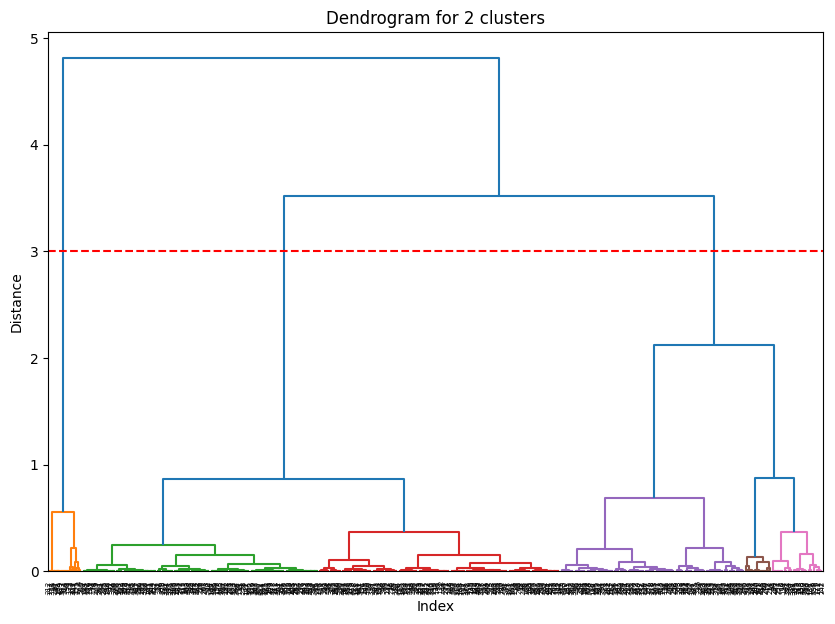

,Number of clusters,Silhouette Score,Calinski Harabasz Score,Davies Bouldin Score
0,2,0.768976,589.547367,0.253823
1,3,0.612455,1202.809630,0.503701
2,4,0.637355,2279.060594,0.474389
3,5,0.635105,2345.547514,0.427899
4,6,0.566307,2885.882129,0.450092
5,7,0.586845,3589.992112,0.455812
6,8,0.593450,4499.956398,0.452326
7,9,0.597561,4942.830790,0.453843
8,10,0.581914,5875.625334,0.450271


In [41]:
# Input file
regions_df = pd.read_csv('regions_df.csv')

data_values = regions_df.values

# Using ward method to create linked data
linked = linkage(data_values, method='ward')

max_clusters = 10
silhouette_scores = []
calinski_scores = []
davies_scores = []

for n_clusters in range(2, max_clusters + 1):
    clusters = fcluster(linked, t=n_clusters, criterion='maxclust')
    sil = silhouette_score(data_values, clusters)
    silhouette_scores.append((n_clusters, sil))
    cal = calinski_harabasz_score(data_values, clusters)
    calinski_scores.append((n_clusters, cal))
    dav = davies_bouldin_score(data_values, clusters)
    davies_scores.append((n_clusters, dav))

best_n_clusters_sil, best_silhouette_score = max(silhouette_scores, key=lambda x: x[1])
best_n_clusters_cal, best_calinski_score = max(calinski_scores, key=lambda x: x[1])
best_n_clusters_dav, best_davies_score = min(davies_scores, key=lambda x: x[1])

print(f'Best silhouette score: {best_silhouette_score} for: {best_n_clusters_sil} clusters')
print(f'Best Calinski Harabasz score: {best_calinski_score} for: {best_n_clusters_cal} clusters')
print(f'Best Davies Bouldin score: {best_davies_score} for: {best_n_clusters_dav} clusters')

# Dendrogram for best number of clusters - regarding silhouette
best_clusters = fcluster(linked, t=best_n_clusters_sil, criterion='maxclust')
plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.7)
plt.axhline(y=3, color='r', linestyle='--')
plt.title(f'Dendrogram for {best_n_clusters_sil} clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# Display all of the obtained metrics
metrics_df = pd.DataFrame({
    'Number of clusters' : [i for i in range(2, max_clusters + 1)],
    'Silhouette Score': [sil[1] for sil in silhouette_scores],
    'Calinski Harabasz Score': [cal[1] for cal in calinski_scores],
    'Davies Bouldin Score': [dav[1] for dav in davies_scores]
})
metrics_df.head(10)


- Both the Silhouette Score and Davies-Bouldin Score identify 2 clusters as the optimal choice for hierarchical clustering, strongly suggesting that the data has a natural division into three well-defined groups.
-   While the high score at 10 clusters (Calinski-Harabasz Score) highlights the possibility of finer substructures, the lower Silhouette and Davies-Bouldin scores for this configuration suggest that these additional clusters might not be as meaningful.

Using the previously determined optimal number of clusters based on silhouette and Davies–Bouldin metrics, hierarchical clustering is applied to the regional data. Each genomic region is assigned a cluster label, allowing us to group regions with similar methylation patterns.

The resulting clusters are visualized in a scatter plot of the Mean_Correlation across genomic windows. A color map is used to clearly distinguish between clusters, making it easier to interpret the clustering results and observe potential regional epigenetic patterns.

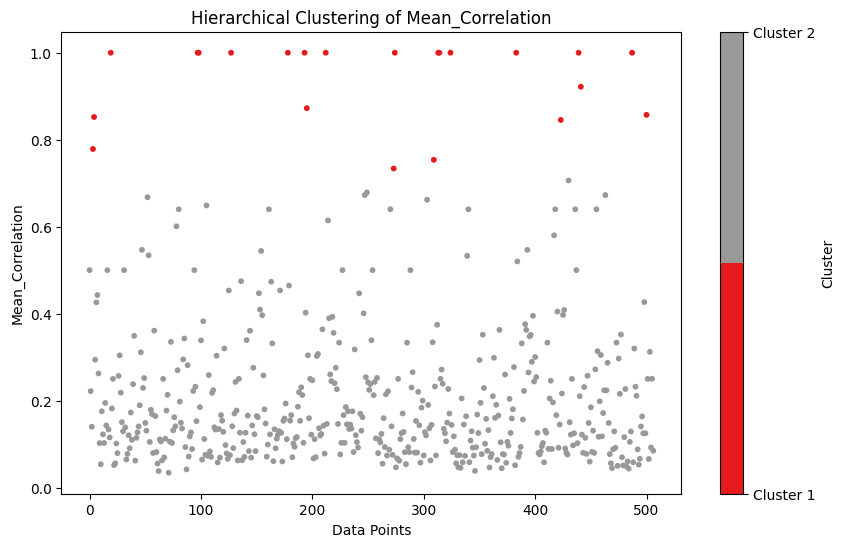

In [42]:
# Visualize clusters
regions_df["Cluster"] = best_clusters

# Define a custom colormap where 
unique_clusters = np.unique(best_clusters)  # На пример [1,2,3...]
num_clusters = len(unique_clusters)
colors = plt.cm.Set1(np.linspace(0, 1, num_clusters))
custom_cmap = ListedColormap(colors)

# Scatter plot for Mean_Correlation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(range(len(regions_df)), 
                      regions_df["Mean_Correlation"], 
                      c=regions_df["Cluster"], 
                      cmap=custom_cmap, 
                      s=10)

# Colour bar
cbar = plt.colorbar(scatter, ticks=np.arange(1, num_clusters + 1))
cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(1, num_clusters + 1)])  
cbar.set_label('Cluster')

# Plot titles and labels
plt.title('Hierarchical Clustering of Mean_Correlation')
plt.xlabel('Data Points')
plt.ylabel('Mean_Correlation')
plt.show()


In [43]:
# Save data frame with sorted cluster information
regions_df_sorted = regions_df.sort_values(by=['Cluster'])
regions_df_sorted.to_csv("region_df_clusters.csv", index = False)

### GMM

This step runs GMM clustering for different cluster counts (2 to 10) on the regional data, evaluates the clustering quality using multiple metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin) and model selection criteria (AIC and BIC). The results help determine the optimal number of clusters for the data.

Best Scores and Parameters:
Best Silhouette Score: 0.5819 - 2 clusters.
Best Calinski-Harabasz Score: 5875.6253 - 2 clusters.
Best Davies-Bouldin Score: 0.4503 - 2 clusters.


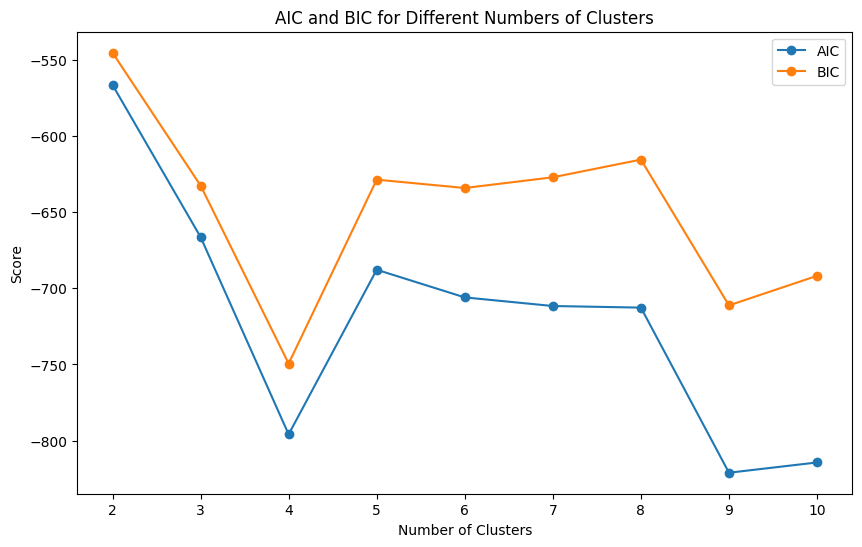

In [44]:
# Input file
regions_df = pd.read_csv('regions_df.csv')

max_clusters = 10
aic_scores = []
bic_scores = []
best_gmm = None
best_n_clusters = 0
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')
silhouette_clusters = None
calinski_clusters = None
davies_clusters = None

for n_clusters in range(2, max_clusters + 1):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(regions_df[['Mean_Correlation']])

    # Now compute the scores using the same dataset
    silhouette = silhouette_score(regions_df[['Mean_Correlation']], clusters) 
    score_calinski_harabasz = calinski_harabasz_score(regions_df[['Mean_Correlation']], clusters)
    score_davies_bouldin = davies_bouldin_score(regions_df[['Mean_Correlation']], clusters) 
    
    aic_scores.append(gmm.aic(regions_df[['Mean_Correlation']]))
    bic_scores.append(gmm.bic(regions_df[['Mean_Correlation']]))

    if silhouette is not None and silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        silhouette_clusters = n_clusters

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        calinski_clusters = n_clusters

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        davies_clusters = n_clusters

print("Best Scores and Parameters:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} - {silhouette_clusters} clusters.")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} - {calinski_clusters} clusters.")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} - {davies_clusters} clusters.")

# Visualization of AIC and BIC results
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), aic_scores, label='AIC', marker='o')
plt.plot(range(2, max_clusters + 1), bic_scores, label='BIC', marker='o')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

- While n_clusters=2 performs best on the Silhouette, Calinski-Harabasz, and Davies-Bouldin metrics, the AIC/BIC values suggest that 4 clusters may better explain the data in terms of model fit.
- The traditional clustering metrics (Silhouette, CH, DB) favor n_clusters=2, suggesting that two broad groups exist in the dataset. However, AIC/BIC suggest 4 clusters, which could indicate:
    - The presence of subclusters within the two main groups.
    - Overfitting if the additional clusters are splitting natural groups unnecessarily.

Using the optimal cluster count identified earlier (4 clusters), GMM is applied to assign each region to a cluster. The distribution of mean correlation values across these clusters is visualized to show how the regions group according to methylation patterns.

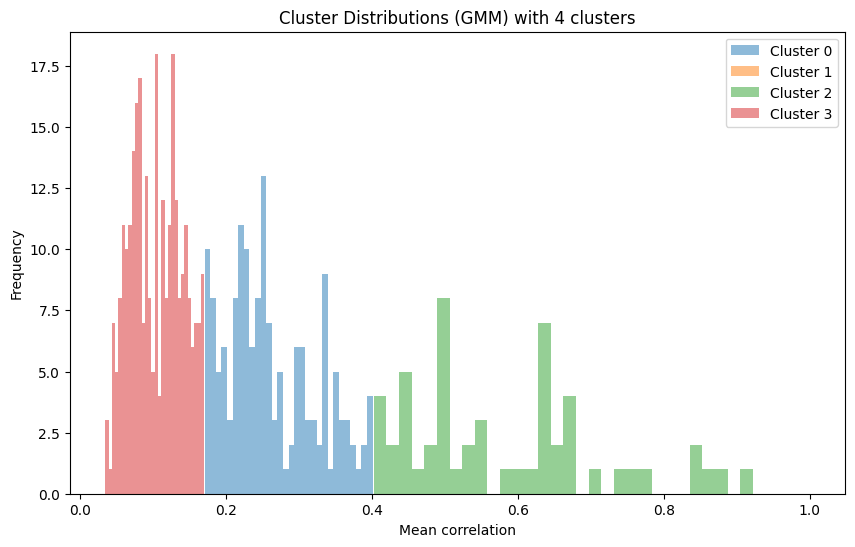

In [45]:
# Apply GMM for the best number of clusters - 4
best_gmm = GaussianMixture(n_components=4, random_state=42)
regions_df['GMM_Cluster'] = best_gmm.fit_predict(regions_df[['Mean_Correlation']])

# Visualization of distribution over clusters
plt.figure(figsize=(10, 6))
for i in range(4):
    cluster_data = regions_df[regions_df['GMM_Cluster'] == i]['Mean_Correlation']
    plt.hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {i}')

plt.title(f'Cluster Distributions (GMM) with 4 clusters')
plt.xlabel('Mean correlation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Spectral Clustering

This section applies Spectral Clustering to the previously derived dataset of genomic regions characterized by their average intra-window methylation correlation. By exploring a range of cluster numbers (from 2 to 14), the algorithm identifies structural groupings based on similarities in methylation patterns across regions. The quality of clustering is evaluated using Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Score to determine the most appropriate clustering configuration.

In [46]:
# Input file
regions_df = pd.read_csv('regions_df.csv')

param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

for params in grid_search:
    spectral = SpectralClustering(n_clusters=params['n_clusters'], affinity='nearest_neighbors', random_state=42)
    clusters = spectral.fit_predict(regions_df[['Mean_Correlation']])

    silhouette = silhouette_score(regions_df[['Mean_Correlation']], clusters)
    score_calinski_harabasz = calinski_harabasz_score(regions_df[['Mean_Correlation']], clusters)
    score_davies_bouldin = davies_bouldin_score(regions_df[['Mean_Correlation']], clusters)
    
    if silhouette is not None and silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params
    
# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette:.4f} Number of clusters: {best_params_silhouette}")
print(f"Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f} Number of clusters: {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin:.4f} Number of clusters: {best_params_davies}")


Best Silhouette Score: -0.0161 Number of clusters: {'n_clusters': 13}
Best Calinski-Harabasz Index: 1.3719 Number of clusters: {'n_clusters': 8}
Best Davies-Bouldin Score: 0.6350 Number of clusters: {'n_clusters': 13}


- The negative Silhouette Score and low Calinski-Harabasz Index highlight that Spectral Clustering struggles to find meaningful clusters in this dataset.
- While the Davies-Bouldin Score suggests better separation at n_clusters=13, it may not be consistent with the overall cluster quality.
- Spectral Clustering depends heavily on the construction of the similarity graph (e.g., the affinity matrix or kernel used). Poorly constructed graphs can lead to suboptimal clustering.
- Based on all this, we can conclude that Spectral clustering is not appropriate algorithm for this clustering task.

## Final Remarks

A comprehensive discussion and detailed analysis of the clustering results, along with their biological interpretation, can be found in the accompanying research paper located within the same repository. This notebook serves as the computational foundation supporting the findings presented in the manuscript.